In [1]:
import sys
import torch
sys.path.append("..")

from pytorch_utils import *
from preprocess import *
from model_container import ModelContainer

In [2]:
resnet50 = ModelContainer(
    nnet = get_instrument_segmentation_model_base(
        Models.RESNETV50
    ),
    returns_dict = True
)

unet = ModelContainer(
    nnet = get_instrument_segmentation_model_base(
        Models.UNET
    ),
    returns_dict = False
)

In [3]:
dataloader = "..\\training\\pickled\\training_128_160.pkl"

In [4]:
resnet50.load_model(torch.load("..\\training\\pickled\\resnet50_model.pkl"))
unet.load_model(torch.load("..\\training\\pickled\\unet_resnet50_model.pkl"))

resnet50.load_loader(dataloader)
unet.load_loader(dataloader)

In [5]:
resnet50_losses = torch.load(r"..\training\pickled\resnet50_losses.pkl")
with open(r"..\training\pickled\unet_resnet50_losses.pkl", "rb") as fp:
    unet_losses = pickle.load(fp)

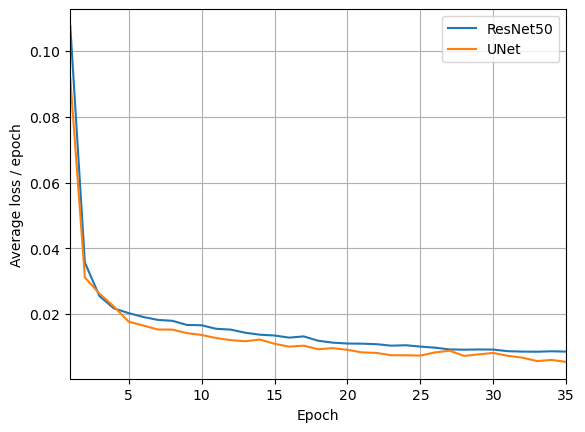

In [6]:
I = 53 # number of samples
N = 35 # number of samples

import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(N) + 1, np.average(np.array(resnet50_losses).reshape(-1, I), axis = 1), label = "ResNet50")
plt.plot(np.arange(N) + 1, np.average(np.array(unet_losses).reshape(-1, I), axis = 1), label = "UNet")
plt.ylabel("Average loss / epoch")
plt.xlabel("Epoch")
plt.xlim([1, N])
plt.grid()
plt.legend()

In [23]:
np.average(np.array(unet_losses).reshape(-1, I), axis = 1)[0]

0.0916523

In [8]:
input_, output_ = load_endovis_videos(DatasetType.TESTING)

# for some reason, two of the videos for the output had an extra frame.
# removing the last frame of said videos in order to somewhat sync them back up,
# but ideally the correct frame would be removed...
DROPOUT = (4496, 1495+1500)

for idx in DROPOUT:
    output_.pop(idx)

input_to_tensor = preprocess_source_endovis_images(input_, (128, 160))
output_to_tensor = preprocess_endovis_target_images(output_, (128, 160))

In [9]:
input_to_tensor.shape

torch.Size([4495, 3, 128, 160])

In [10]:
results = []

for idx in range(input_to_tensor.shape[0]):
    results.append(unet.test(
        input_to_tensor[idx:idx+1], 
        output_to_tensor[idx:idx+1]
    ))

In [11]:
results

[0.48875001072883606,
 0.47795969247817993,
 0.5035095810890198,
 0.5195005536079407,
 0.5122026801109314,
 0.5267199277877808,
 0.5266871452331543,
 0.5168054103851318,
 0.5139146447181702,
 0.50765460729599,
 0.5113011598587036,
 0.5099176168441772,
 0.5,
 0.483065128326416,
 0.4896087944507599,
 0.5128595232963562,
 0.4808776378631592,
 0.48451128602027893,
 0.47048220038414,
 0.48126888275146484,
 0.4874076247215271,
 0.4842168092727661,
 0.4686705470085144,
 0.46419456601142883,
 0.45357412099838257,
 0.43422234058380127,
 0.45986273884773254,
 0.49312230944633484,
 0.4614468514919281,
 0.4432545006275177,
 0.4753510653972626,
 0.5243757367134094,
 0.5402079820632935,
 0.48201650381088257,
 0.450997918844223,
 0.4313725531101227,
 0.4541458189487457,
 0.49118539690971375,
 0.5641103386878967,
 0.52946537733078,
 0.5140012502670288,
 0.5643362402915955,
 0.5101367235183716,
 0.5440528392791748,
 0.5212428569793701,
 0.540549099445343,
 0.5544775128364563,
 0.4674106538295746,
 0.56

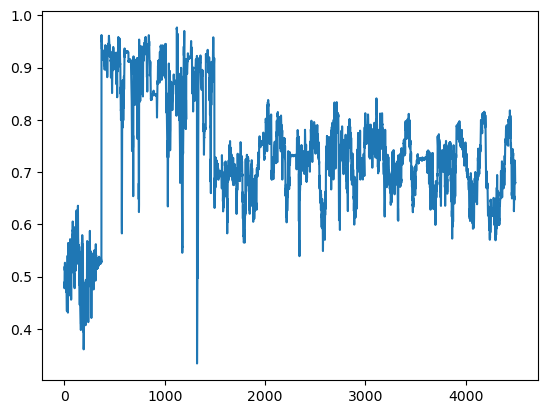

In [12]:
plt.plot(results)

In [13]:
np.average(results)

0.7381045158434497

In [14]:
results2 = []

for idx in range(input_to_tensor.shape[0]):
    results2.append(resnet50.test(
        input_to_tensor[idx:idx+1], 
        output_to_tensor[idx:idx+1]
    ))

In [24]:
np.average(results2)

0.67487949208171

In [18]:
SIZES = (370, 375, 375, 375, 1500, 1500)
INDEXES = [0]
for size in SIZES:
    INDEXES.append(INDEXES[-1] + size - 1)

Average coeff: 0.3262 +/- 0.0487
Average coeff: 0.5091 +/- 0.0483
------------
Average coeff: 0.8925 +/- 0.0531
Average coeff: 0.8925 +/- 0.0602
------------
Average coeff: 0.8840 +/- 0.0506
Average coeff: 0.8770 +/- 0.0555
------------
Average coeff: 0.8259 +/- 0.1024
Average coeff: 0.8520 +/- 0.0979
------------
Average coeff: 0.6593 +/- 0.0622
Average coeff: 0.7172 +/- 0.0527
------------
Average coeff: 0.6323 +/- 0.0523
Average coeff: 0.7137 +/- 0.0538
------------


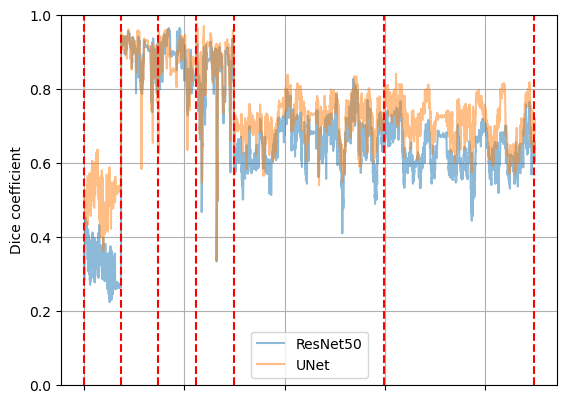

In [19]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(results2, label = "ResNet50", alpha = 0.5)
ax.plot(results, label = "UNet", alpha = 0.5)
for idx in range(len(INDEXES)):
    ax.axvline(INDEXES[idx], 0, 1, color = "red", linestyle = "dashed")
    if idx != len(INDEXES)-1:
        for r in (results2, results):
            print(f"Average coeff: {np.average(r[INDEXES[idx]:INDEXES[idx+1]+1]):.4f} +/- {np.std(r[INDEXES[idx]:INDEXES[idx+1]+1]):.4f}")
        print("------------")

ax.set_axisbelow(True)
ax.set_ylim([0.0, 1.0])
ax.set_ylabel("Dice coefficient")
ax.set_xticklabels([])
ax.legend()
ax.grid()

In [ ]:
for idx in range(len(INDEXES)):
    ax.axvline(INDEXES[idx], 0, 1, color = "red", linestyle = "dashed")
    if idx != len(INDEXES)-1:
        for r in (results2, results):
            print(f"Average coeff: {np.average(r[INDEXES[idx]:INDEXES[idx+1]+1]):.4f} +/- {np.std(r[INDEXES[idx]:INDEXES[idx+1]+1]):.4f}")
        print("------------")


In [26]:
(370*0.3262 + 1500*0.6593 + 1500*0.6323) / 3370

0.6107103857566766

In [27]:
(370*0.5091 + 1500*0.7172 + 1500*0.7137) / 3370

0.6927943620178041

In [28]:
(375*0.8925 + 375*0.8757 + 375*0.8259) / 1125

0.8647

In [29]:
(375*0.8925 + 375*0.8869 + 375*0.8520) / 1125

0.8771333333333334